In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os
import torch
import numpy as np
from dataset import ModelNet40, collate_fn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from dataAugmenter import *

In [25]:
def plot_pcu(vector):
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    xdata = vector[:, 0]
    ydata = vector[:, 1]
    zdata = vector[:, 2]
    
    ax.scatter3D(xdata, ydata, zdata, cmap='Greens')
    plt.show()

## Dataset Path

In [26]:
os.chdir("/home/arrow/Desktop/University Materials/COMP 399/Research")
print(os.getcwd())

modelnet40_path = os.path.join(os.getcwd(), 'ModelNet40')
print(modelnet40_path)
SAMPLE_SIZE = 2048
TEST = False
SAMPLING_METHOD = 'uni-sph'
batch_size = 16

/home/arrow/Desktop/University Materials/COMP 399/Research
/home/arrow/Desktop/University Materials/COMP 399/Research/ModelNet40


## Dataset Instance

In [27]:
dataset = ModelNet40(dataset_path=modelnet40_path, test=TEST, sample_size=SAMPLE_SIZE, sampling=SAMPLING_METHOD)

In [28]:
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [29]:
points = None
labels = None
counter = 0
for (d,s, l) in data_loader:
    if counter == 1:
        break
    counter +=1
    labels = s
    points = d

/home/arrow/Desktop/University Materials/COMP 399/Research/TransformersFor3dPointCLouds/data/dataset.py:156: RuntimeWarning: divide by zero encountered in true_divide
  rescaled_vecs = vec * (R / norms)
/home/arrow/Desktop/University Materials/COMP 399/Research/TransformersFor3dPointCLouds/data/dataset.py:156: RuntimeWarning: invalid value encountered in multiply
  rescaled_vecs = vec * (R / norms)


In [30]:
print(points[1].shape, labels)

torch.Size([2048, 3]) tensor([15, 15, 29, 19])


## Test Shuffle

In [31]:
rotated = rotate_point_cloud(points[1])

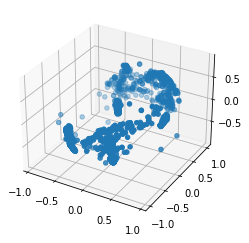

In [32]:
plot_pcu(points[1])

## Test Rotation

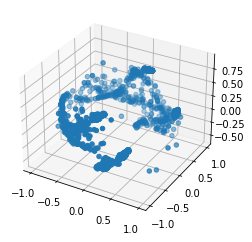

In [33]:
plot_pcu(rotated)

In [34]:
z_r = rotate_point_cloud_z(points[1])

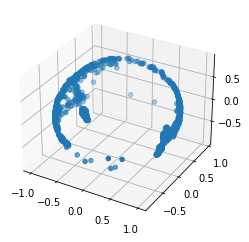

In [35]:
plot_pcu(z_r)

In [36]:
r_a = rotate_point_cloud_by_angle(points[1], np.pi / 2)

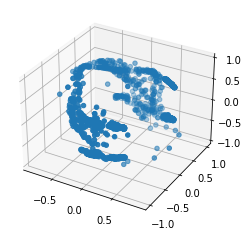

In [37]:
plot_pcu(r_a)

In [38]:
r_p = rotate_perturbation_point_cloud(points[1], angle_sigma=0.01, angle_clip=0.18)

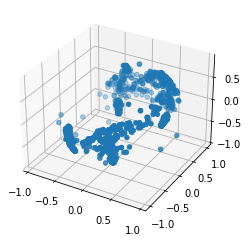

In [39]:
plot_pcu(r_p)

In [40]:
r_j = jitter_point_cloud(points[1], sigma=1, clip=0.09)

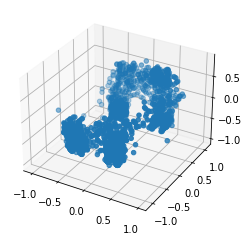

In [41]:
plot_pcu(r_j)

## Test Shiftting

In [42]:
s = shift_point_cloud(points[1], shift_range=0.1)

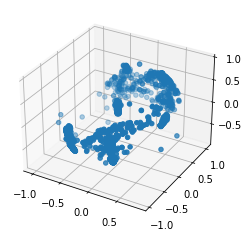

In [43]:
plot_pcu(s)

In [44]:
scale = random_scale_point_cloud(points[1], scale_low=0.1, scale_high=1.25)

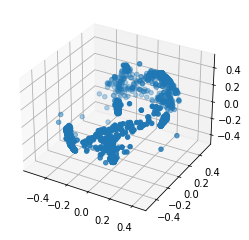

In [45]:
plot_pcu(scale)

print(os.getcwd())

In [58]:
print(os.listdir())
modelNet_path = os.path.join(os.getcwd(), 'modelnet40_ply_hdf5_2048')
print(modelNet_path)

['ModelNet40', 'metadata_modelnet40.csv', 'PointTransformer.png', 'dataset.txt', 'Attention.py', 'archive (1).zip', 'm.bashrc', 'aug.h5', 'modelnet40_ply_hdf5_2048', 'New Text Document.txt', 'TransformersFor3dPointCLouds', 's.sh']
/home/arrow/Desktop/University Materials/COMP 399/Research/modelnet40_ply_hdf5_2048


In [113]:
from TransformersFor3dPointCLouds.data.dataset_h5 import *

In [122]:
dataset = NormalizedModelNet40(dataset_path=modelNet_path, partition='train', sample_size=1024, sampling_method='fps')

i: 0, n: 264
i: 1, n: 783
i: 2, n: 374
i: 3, n: 716
i: 4, n: 317
i: 5, n: 554
i: 6, n: 825
i: 7, n: 692
i: 8, n: 0
i: 9, n: 722
i: 10, n: 810
i: 11, n: 752
i: 12, n: 689
i: 13, n: 780
i: 14, n: 689
i: 15, n: 740
i: 16, n: 718
i: 17, n: 734
i: 18, n: 744
i: 19, n: 765
i: 20, n: 740
i: 21, n: 605
i: 22, n: 424
i: 23, n: 689
i: 24, n: 801
i: 25, n: 658
i: 26, n: 650
i: 27, n: 785
i: 28, n: 774
i: 29, n: 761
i: 30, n: 209
i: 31, n: 765
i: 32, n: 799
i: 33, n: 497
i: 34, n: 726
i: 35, n: 545
i: 36, n: 622
i: 37, n: 414
i: 38, n: 802
i: 39, n: 786
25720


## Investigate augmented

In [123]:
all_data = []
all_label = []


f = h5py.File(os.path.join(modelNet_path, 'augmented_data.h5'), 'r')
data = f['data'][:].astype('float32')
label = f['labels'][:].astype('int64')
f.close()
all_data.append(data)
all_label.append(label)

all_data = np.concatenate(all_data, axis=0)
all_label = np.concatenate(all_label, axis=0)


In [124]:
print(all_label[-1])

39


In [125]:
print(all_data.shape)

(35560, 2048, 3)


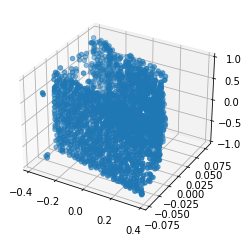

In [118]:
plot_pcu(all_data[20])